In [2]:
from scipy.linalg import toeplitz
import numpy as np
from sklearn.model_selection import KFold
from numpy.linalg import inv
from scipy.stats import zscore
import matplotlib.pyplot as plt
import time
np.random.seed(0)

# Helpers

In [3]:
def toeplitz_cov(n):
    cov = toeplitz(np.exp(-(np.arange(n*1.0))**2/n))
    return cov

In [4]:
def R2(Pred,Real):
    SSres = np.mean((Real-Pred)**2,0)
    SStot = np.var(Real,0)
    return np.nan_to_num(1-SSres/SStot)

def ridge(X,Y,lmbda):
    return np.dot(inv(X.T.dot(X)+lmbda*np.eye(X.shape[1])),X.T.dot(Y))

def ridge_by_lambda(X, Y, Xval, Yval, lambdas):
    error = np.zeros((lambdas.shape[0],Y.shape[1]))
    for idx,lmbda in enumerate(lambdas):
        weights = ridge(X,Y,lmbda)
        error[idx] = 1 - R2(np.dot(Xval,weights),Yval)
    return error

def cross_val_ridge(train_features, train_data, n_splits=10, lambdas=np.array([10**i for i in range(-6, 10)])):
    n_voxels = train_data.shape[1]
    n_lambdas = lambdas.shape[0]
    n_feats = train_features.shape[1]
    r_cv = np.zeros((n_lambdas, n_voxels))
    
    kf = KFold(n_splits=n_splits)
    for icv, (trn, val) in enumerate(kf.split(train_data)):
        cost = ridge_by_lambda(train_features[trn], train_data[trn], train_features[val], train_data[val], lambdas=lambdas)
        r_cv += cost
        
    argmin_lambda = np.argmin(r_cv,axis = 0)
    weights = np.zeros((n_feats,n_voxels))
    for idx_lambda in range(lambdas.shape[0]):
        idx_vox = argmin_lambda == idx_lambda
        weights[:,idx_vox] = ridge(train_features, train_data[:,idx_vox],lambdas[idx_lambda])
    min_lambdas = np.array([lambdas[i] for i in argmin_lambda])

    return weights, min_lambdas

In [5]:
def corr(X,Y):
    return np.mean(zscore(X)*zscore(Y),0)

In [6]:
def get_plot_ys(corrs, y_keys):
    ys, ys_std = {}, {}
    ys['v1p1'], ys['v2p1'] = [], []
    ys_std['v1p1'], ys_std['v2p1'] = [], []
    for k in y_keys:
        ys['v1p1'].append(np.mean(np.array(corrs['v1p1'][k])))
        ys_std['v1p1'].append(np.std(np.array(corrs['v1p1'][k])))
        ys['v2p1'].append(np.mean(np.array(corrs['v2p1'][k])))
        ys_std['v2p1'].append(np.std(np.array(corrs['v2p1'][k])))
    return ys, ys_std

### 1. Generate random features and weights

In [7]:
def generate_features_and_weights(n, ms):
    m1, m2, m3, m12 = ms
    # Features
    x1 = np.random.multivariate_normal(mean=np.zeros(m1), cov=toeplitz_cov(m1), size=(n,)) if m1>0 else np.array([]).reshape(n,0)
    x2 = np.random.multivariate_normal(mean=np.zeros(m2), cov=toeplitz_cov(m2), size=(n,)) if m2>0 else np.array([]).reshape(n,0)
    x3 = np.random.multivariate_normal(mean=np.zeros(m3), cov=toeplitz_cov(m3), size=(n,)) if m3>0 else np.array([]).reshape(n,0)
    x12 = np.random.multivariate_normal(mean=np.zeros(m12), cov=toeplitz_cov(m12), size=(n,)) if m12>0 else np.array([]).reshape(n,0)
    x = np.concatenate((x1, x2, x3, x12), axis=1) # x: (n, m1+m2+m3+m12)
    
    # Weights
    w1 = np.random.rand(m1, 1)
    w2 = np.random.rand(m2, 1)
    w12 = np.random.rand(m12, 1)
    return (x, x1, x2, x3, x12), (w1, w2, w12)

### 2. Generate voxel data

In [8]:
def generate_voxels(n, ms, xs, ws, eps_stds, use_shared_information):
    # Initialize noise
    eps_std1, eps_std2, eps_std12 = eps_stds
    eps1 = np.random.normal(loc=0.0, scale=eps_std1, size=(n, 1))
    eps2 = np.random.normal(loc=0.0, scale=eps_std2, size=(n, 1))
    eps12 = np.random.normal(loc=0.0, scale=eps_std12, size=(n, 1))
    
    # Generate voxel data
    _, x1, x2, _, x12 = xs
    w1, w2, w12 = ws
    m1, m2, _, m12 = ms
    if use_shared_information:
        v12 = np.dot(x12, w12) if (m12 > 0) else np.zeros((n,1))
        v1 = zscore(np.dot(x1, w1) + v12) + eps1 + eps12 if (m1 > 0) else zscore(v12) + eps1 + eps12
        v2 = zscore(np.dot(x2, w2) + v12) + eps2 + eps12 if (m2 > 0) else zscore(v12) + eps2 + eps12
    else:
        v12 = None
        v1 = zscore(np.dot(x1, w1)) + eps1 if (m1 > 0) else eps1
        v2 = zscore(np.dot(x2, w2)) + eps2 if (m2 > 0) else eps2
    return (v1, v2, v12)

### 3. Combine everything to perform one experiment run

In [9]:
def perform_experiment(n, ms, eps_stds, use_shared_information):
    # Generate features, weights, voxel data
    xs, ws = generate_features_and_weights(n, ms)
    vs = generate_voxels(n, ms, xs, ws, eps_stds, use_shared_information)

    # Estimate weights using ridge
    x = xs[0]
    v1, v2 = vs[0], vs[1]
    estimated_w1, lambdas1 = cross_val_ridge(x, v1)
    estimated_w2, lambdas2 = cross_val_ridge(x, v2)
    
    # Compute predictions
    p1 = np.dot(x, estimated_w1)
    p2 = np.dot(x, estimated_w2)
                
    # Compute relevant correlations
    corr_v1v2 = corr(v1, v2)
    corr_v1p1 = corr(v1, p1)
    corr_v2p1 = corr(v2, p1)
    corr_v2p2 = corr(v2, p2)
    return corr_v1v2, corr_v1p1, corr_v2p1

# Debug Runs

In [ ]:
# NOTE: This section is useful when you want to play around with parameter values, use the python debugger, etc.
eps_std12 = 1.0
m1, m2, m3, m12 = 3, 3, 4, 30
all_eps_stds = [i*0.5 for i in range(7)] # only for eps_std1 and eps_std2
n = 500 # no. of train samples
m = 40 # total no. of features
n_repetitions = 25
use_shared_information = True

corrs = {}
corrs['v1v2'], corrs['v1p1'], corrs['v2p1'] = {}, {}, {}
for eps_std1 in all_eps_stds:
    s = time.time()
    corrs['v1v2'][eps_std1], corrs['v1p1'][eps_std1], corrs['v2p1'][eps_std1] = {}, {}, {}
    for eps_std2 in all_eps_stds:
        corrs['v1v2'][eps_std1][eps_std2], corrs['v1p1'][eps_std1][eps_std2], corrs['v2p1'][eps_std1][eps_std2] = [], [], []
        for i in range(n_repetitions):
            ms = [m1, m2, m3, m12]
            eps_stds = [eps_std1, eps_std2, eps_std12] # same standard deviation for all voxel noises
            corr_v1v2, corr_v1p1, corr_v2p1 = perform_experiment(n, ms, eps_stds, use_shared_information)

            corrs['v1v2'][eps_std1][eps_std2].append(corr_v1v2)
            corrs['v1p1'][eps_std1][eps_std2].append(corr_v1p1)
            corrs['v2p1'][eps_std1][eps_std2].append(corr_v2p1)
    e = time.time()

In [ ]:
# Plot contour plots
X, Y, Z_v1v2, Z_p1v2 = np.zeros((7,7)), np.zeros((7,7)), np.zeros((7,7)), np.zeros((7,7))
for i, eps_stdx in enumerate(all_eps_stds):
    for j, eps_stdy in enumerate(all_eps_stds):
        X[i][j] = eps_stdx
        Y[i][j] = eps_stdy
        Z_v1v2[i][j] = np.mean(np.array(corrs['v1v2'][eps_stdx][eps_stdy]))
        Z_p1v2[i][j] = np.mean(np.array(corrs['v2p1'][eps_stdx][eps_stdy]))

plt.contourf(X, Y, Z_v1v2, cmap='RdGy')
plt.title('cross-voxel correlation vs.\nv1 noise, v2 noise')
plt.xlabel('stddev of noise for v1')
plt.ylabel('stddev of noise for v2')
plt.colorbar()
plt.show()

plt.contourf(X, Y, Z_p1v2, cmap='RdGy')
plt.title('cross-voxel predictivity vs.\nv1 noise, v2 noise')
plt.xlabel('stddev of noise for v1')
plt.ylabel('stddev of noise for v2')
plt.colorbar()
plt.show()

# How Predictivity Varies with Different Noise Levels

In [12]:
#######################
# Experiment Settings #
#######################
use_shared_information = True # TOGGLE: [True, False]

n = 500 # no. of train samples
m1, m2, m3, m12 = 10, 10, 10, 10 # no. of features
n_repetitions = 100
all_eps_stds = [i*0.25 for i in range(21)]

corrs = {}
corrs['v1p1'], corrs['v2p1'] = {}, {}

################################################
# Run multiple simulations at each noise level #
################################################
for eps_std in all_eps_stds:
    print("eps_std={}".format(eps_std))
    corrs['v1p1'][eps_std], corrs['v2p1'][eps_std] = [], []
    for i in range(n_repetitions):
        ms = [m1, m2, m3, m12]
        eps_stds = [eps_std, eps_std, eps_std] # same noise level for all voxels
        _, corr_v1p1, corr_v2p1 = perform_experiment(n, ms, eps_stds, use_shared_information)

        corrs['v1p1'][eps_std].append(corr_v1p1)
        corrs['v2p1'][eps_std].append(corr_v2p1)

eps_std=0.0
eps_std=0.25
eps_std=0.5
eps_std=0.75
eps_std=1.0
eps_std=1.25
eps_std=1.5
eps_std=1.75
eps_std=2.0
eps_std=2.25
eps_std=2.5
eps_std=2.75
eps_std=3.0
eps_std=3.25
eps_std=3.5
eps_std=3.75
eps_std=4.0
eps_std=4.25
eps_std=4.5
eps_std=4.75
eps_std=5.0


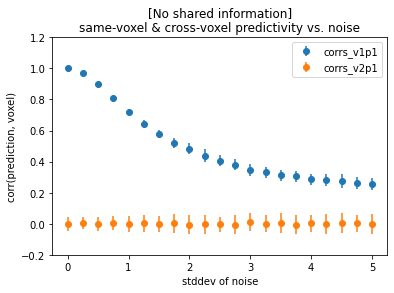

In [10]:
ys, ys_std = get_plot_ys(corrs, all_eps_stds)
plt.errorbar(all_eps_stds, ys['v1p1'], yerr=ys_std['v1p1'], fmt='o', label="corrs_v1p1")
plt.errorbar(all_eps_stds, ys['v2p1'], yerr=ys_std['v2p1'], fmt='o', label="corrs_v2p1")
plt.xlabel('stddev of noise')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('[No shared information]\nsame-voxel & cross-voxel predictivity vs. noise')
plt.legend()
plt.savefig('spatial_generalization_experiments/plots/predictivity_generalization-vary_all_eps-m12_0.png')

In [11]:
np.save('spatial_generalization_experiments/corrs/predictivity_generalization-vary_all_eps-m12_0.npy', corrs)

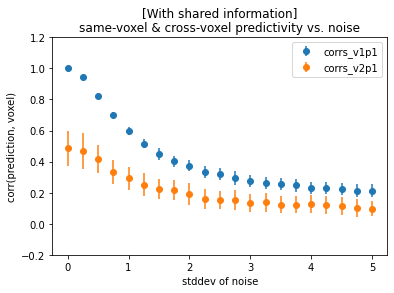

In [13]:
ys, ys_std = get_plot_ys(corrs, all_eps_stds)
plt.errorbar(all_eps_stds, ys['v1p1'], yerr=ys_std['v1p1'], fmt='o', label="corrs_v1p1")
plt.errorbar(all_eps_stds, ys['v2p1'], yerr=ys_std['v2p1'], fmt='o', label="corrs_v2p1")
plt.xlabel('stddev of noise')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('[With shared information]\nsame-voxel & cross-voxel predictivity vs. noise')
plt.legend()
plt.savefig('spatial_generalization_experiments/plots/predictivity_generalization-vary_all_eps-m12_0.png')

In [14]:
np.save('spatial_generalization_experiments/corrs/predictivity_generalization-vary_all_eps-m12_0.npy', corrs)

# How Predictivity Varies with Proportion of Shared Information

In [16]:
#######################
# Experiment Settings #
#######################
eps_std = 5. # TOGGLE: [0., 1., 2., 3., 4., 5.]
m = 40 # total no. of features
all_m12s = [i for i in range(0,m+5,5)]

n = 500 # no. of train samples
n_repetitions = 100
use_shared_information = True

corrs = {}
corrs['v1p1'], corrs['v2p1'] = {}, {}

#########################################
# Run multiple simulations for each m12 #
#########################################
for m12 in all_m12s:
    print("m12={}".format(m12))
    rem_m_size = (m-m12)//3
    m1, m2, m3 = rem_m_size, rem_m_size, rem_m_size
    m3 += (m-m12)%3
    corrs['v1p1'][m12], corrs['v2p1'][m12] = [], []
    for i in range(n_repetitions):
        ms = [m1, m2, m3, m12]
        eps_stds = [eps_std, eps_std, eps_std] # same noise level for all voxels
        _, corr_v1p1, corr_v2p1 = perform_experiment(n, ms, eps_stds, use_shared_information)

        corrs['v1p1'][m12].append(corr_v1p1)
        corrs['v2p1'][m12].append(corr_v2p1)

m12=0
m12=5
m12=10
m12=15
m12=20
m12=25
m12=30
m12=35
m12=40


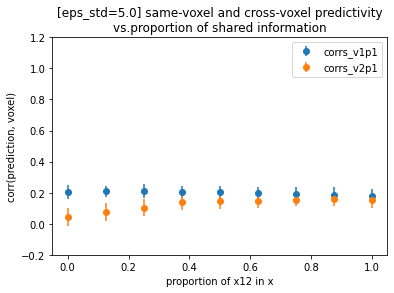

In [17]:
ys, ys_std = get_plot_ys(corrs, all_m12s)
plt.errorbar([m12/m for m12 in all_m12s], ys['v1p1'], yerr=ys_std['v1p1'], fmt='o', label="corrs_v1p1")
plt.errorbar([m12/m for m12 in all_m12s], ys['v2p1'], yerr=ys_std['v2p1'], fmt='o', label="corrs_v2p1")
plt.xlabel('proportion of x12 in x')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('[eps_std={}] same-voxel and cross-voxel predictivity\nvs.proportion of shared information'.format(eps_std))
plt.legend()
plt.savefig('spatial_generalization_experiments/plots/predictivity_generalization-vary_m12-all_eps_{}.png'.format(eps_std))

In [18]:
np.save('spatial_generalization_experiments/corrs/predictivity_generalization-vary_m12-all_eps_{}.npy'.format(eps_std), corrs)

# How Predictivity Varies with Noise Levels Per Voxel

In [64]:
#######################
# Experiment Settings #
#######################
eps_std12 = 2.0 # NOTE: Chosen randomly. Might be worth experimenting with this.
all_m12s = [0, 10, 20, 30]
all_eps_stds = [i*0.25 for i in range(21)] # only for eps_std1 and eps_std2

n = 500 # no. of train samples
m = 40 # total no. of features
n_repetitions = 100
use_shared_information = True

corrs = {}

########################################################################
# For each m12, run multiple simulations per (eps_std1, eps_std2) pair #
########################################################################
for m12 in all_m12s:
    print("m12={}".format(m12))
    rem_m_size = (m-m12)//3
    m1, m2, m3 = rem_m_size, rem_m_size, rem_m_size
    m3 += (m-m12)%3
    corrs[m12] = {}
    corrs[m12]['v1v2'], corrs[m12]['v1p1'], corrs[m12]['v2p1'] = {}, {}, {}
    
    for eps_std1 in all_eps_stds:
        s = time.time()
        corrs[m12]['v1v2'][eps_std1], corrs[m12]['v1p1'][eps_std1], corrs[m12]['v2p1'][eps_std1] = {}, {}, {}
        for eps_std2 in all_eps_stds:
            corrs[m12]['v1v2'][eps_std1][eps_std2], corrs[m12]['v1p1'][eps_std1][eps_std2], corrs[m12]['v2p1'][eps_std1][eps_std2] = [], [], []
            for i in range(n_repetitions):
                ms = [m1, m2, m3, m12]
                eps_stds = [eps_std1, eps_std2, eps_std12] # same standard deviation for all voxel noises
                corr_v1v2, corr_v1p1, corr_v2p1 = perform_experiment(n, ms, eps_stds, use_shared_information)

                corrs[m12]['v1v2'][eps_std1][eps_std2].append(corr_v1v2)
                corrs[m12]['v1p1'][eps_std1][eps_std2].append(corr_v1p1)
                corrs[m12]['v2p1'][eps_std1][eps_std2].append(corr_v2p1)
        e = time.time()
        print("Time Taken for eps_std1={}: {}s".format(eps_std1, e-s))

m12=0
Time Taken for eps_std1=0.0: 192.5304090976715s
Time Taken for eps_std1=0.25: 195.4997022151947s
Time Taken for eps_std1=0.5: 209.6242287158966s
Time Taken for eps_std1=0.75: 220.40627479553223s
Time Taken for eps_std1=1.0: 220.67461490631104s
Time Taken for eps_std1=1.25: 207.5687439441681s
Time Taken for eps_std1=1.5: 171.03461503982544s
Time Taken for eps_std1=1.75: 171.68120098114014s
Time Taken for eps_std1=2.0: 172.6101598739624s
Time Taken for eps_std1=2.25: 188.244784116745s
Time Taken for eps_std1=2.5: 168.6600890159607s
Time Taken for eps_std1=2.75: 176.47813510894775s
Time Taken for eps_std1=3.0: 169.9619870185852s
Time Taken for eps_std1=3.25: 174.28217601776123s
Time Taken for eps_std1=3.5: 180.72418403625488s
Time Taken for eps_std1=3.75: 182.6532530784607s
Time Taken for eps_std1=4.0: 178.17935514450073s
Time Taken for eps_std1=4.25: 171.02941608428955s
Time Taken for eps_std1=4.5: 184.72973489761353s
Time Taken for eps_std1=4.75: 182.6183578968048s
Time Taken for 

IndexError: list index out of range

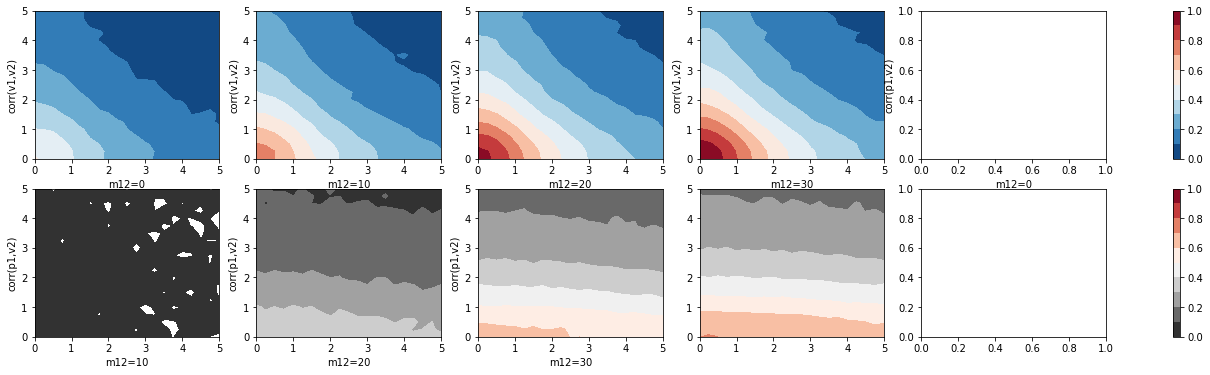

In [93]:
fig, axs = plt.subplots(2, 4, figsize=(21,7))
for col in range(4):
    m12 = all_m12s[col]
    # Format data for easy 2D plotting
    X, Y, Z_v1v2, Z_p1v2 = np.zeros((21,21)), np.zeros((21,21)), np.zeros((21,21)), np.zeros((21,21))
    for i, eps_stdx in enumerate(all_eps_stds):
        for j, eps_stdy in enumerate(all_eps_stds):
            X[i][j] = eps_stdx
            Y[i][j] = eps_stdy
            Z_v1v2[i][j] = np.mean(np.array(corrs[m12]['v1v2'][eps_stdx][eps_stdy]))
            Z_p1v2[i][j] = np.mean(np.array(corrs[m12]['v2p1'][eps_stdx][eps_stdy]))
    # Plot contour plot
    ax1 = axs[0][col].contourf(X, Y, Z_v1v2, cmap='RdBu_r', vmin=0, vmax=1, levels=[0.1*i for i in range(11)])
    ax2 = axs[1][col].contourf(X, Y, Z_p1v2, cmap='RdGy_r', vmin=0, vmax=1, levels=[0.1*i for i in range(11)])
fig.colorbar(ax1, ax=axs[0, :])
fig.colorbar(ax2, ax=axs[1, :])

ylabels = ['corr(v1,v2)', 'corr(p1,v2)']
for i, ax in enumerate(axs.flat):
    ax.set(xlabel='m12={}'.format(all_m12s[i%4]), ylabel=ylabels[i//4])
        
for ax in axs.flat:
    ax.label_outer()
plt.savefig('spatial_generalization_experiments/plots/predictivity_connectivity-vary_m12-vary_eps1_eps2-eps12_{}.png',format(eps_std12))

In [66]:
np.save('spatial_generalization_experiments/corrs/predictivity_connectivity-vary_m12-vary_eps1_eps2-eps12_{}.npy'.format(eps_std12), corrs)

# Old Code Segments

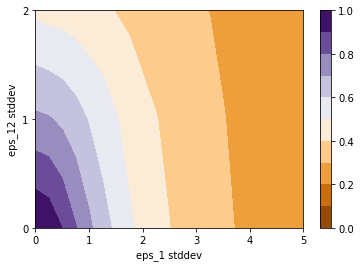

<Figure size 432x288 with 0 Axes>

In [109]:
# Plot how corr(v1,p1) as we vary shared noise vs. v1 specific noise 
#(we expect same effect from both noises for corr(v1,p1) so circular patter makes sense)
all_eps_std12s = [0.0, 1.0, 2.0]
eps_std1s = [i*0.25 for i in range(21)]

X, Y, Z_v1p1 = np.zeros((len(eps_std1s),len(all_eps_std12s))), np.zeros((len(eps_std1s),len(all_eps_std12s))), np.zeros((len(eps_std1s),len(all_eps_std12s)))
for j, eps_std12 in enumerate(all_eps_std12s):
    corrs = np.load('spatial_generalization_experiments/corrs/predictivity_connectivity-vary_m12-vary_eps1_eps2-eps12_{}.npy'.format(eps_std12), allow_pickle=True).item()
    for i, eps_std1 in enumerate(eps_std1s):
        X[i][j] = eps_std1
        Y[i][j] = eps_std12
        Z_v1p1[i][j] = np.mean(np.array(corrs[0]['v1p1'][eps_std1][0.0]))
# Plot contour plot
plt.contourf(X, Y, Z_v1p1, cmap='PuOr', vmin=0, vmax=1, levels=[0.1*i for i in range(11)])
plt.colorbar()
plt.ylabel('eps_12 stddev')
plt.xlabel('eps_1 stddev')
plt.yticks([0.0,1.0,2.0])
plt.show()

plt.savefig('spatial_generalization_experiments/plots/predictivity-vary_eps1_eps12.png')

## How Predictivity Varies with Noise Levels (No Repetitions)

In [ ]:
# Generate random features & weights

n = 50 # no. of train samples
m1, m2, m3, m12 = 10, 10, 10, 10 # no. of features

x1 = np.random.multivariate_normal(mean=np.random.rand(m1), cov=toeplitz_cov(m1), size=(n,))
x2 = np.random.multivariate_normal(mean=np.random.rand(m2), cov=toeplitz_cov(m2), size=(n,))
x3 = np.random.multivariate_normal(mean=np.random.rand(m3), cov=toeplitz_cov(m3), size=(n,))
x12 = np.random.multivariate_normal(mean=np.random.rand(m12), cov=toeplitz_cov(m12), size=(n,))
x = np.concatenate((x1, x2, x3, x12), axis=1) # x: (n, m1+m2+m3+m12)

w1 = np.random.rand(m1, 1)
w2 = np.random.rand(m2, 1)
w12 = np.random.rand(m12, 1)

# Generate voxel data and use ridge for prediction

eps_stds = [i*0.05 for i in range(21)]
use_eps1, use_eps2, use_eps12 = True, True, True
use_shared_information = True

corrs_v1p1, corrs_v2p2, corrs_v1p2, corrs_v2p1 = [], [], [], []
for eps_std in eps_stds:
    # Initialize noise
    eps1 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1)) if use_eps1 else 0
    eps2 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1)) if use_eps2 else 0
    eps12 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1)) if use_eps12 else 0
    
    # Generate voxel data
    if use_shared_information:
        v12 = np.dot(x12, w12) + eps12
        v1 = np.dot(x1, w1) + v12 + eps1
        v2 = np.dot(x2, w2) + v12 + eps2
    else:
        v12 = np.dot(x12, w12) + eps12
        v1 = np.dot(x1, w1) + eps1
        v2 = np.dot(x2, w2) + eps2
    
    # Estimate weights using ridge
    estimated_w1, lambdas1 = cross_val_ridge(x, v1)
    estimated_w2, lambdas2 = cross_val_ridge(x, v2)
    # Compute predictions
    p1 = np.dot(x, estimated_w1)
    p2 = np.dot(x, estimated_w2)
    
    # Assess predictions
    corr_v1p1 = corr(v1, p1)
    corr_v2p2 = corr(v2, p2)
    # Assess predictivity across voxels
    corr_v1p2 = corr(v1, p2)
    corr_v2p1 = corr(v2, p1)
    
    corrs_v1p1.append(corr_v1p1)
    corrs_v2p2.append(corr_v2p2)
    corrs_v1p2.append(corr_v1p2)
    corrs_v2p1.append(corr_v2p1)# Generate random features & weights

In [ ]:
plt.plot(eps_stds, corrs_v1p1, label="corrs_v1p1")
plt.plot(eps_stds, corrs_v2p2, label="corrs_v2p2")
plt.plot(eps_stds, corrs_v1p2, label="corrs_v1p2")
plt.plot(eps_stds, corrs_v2p1, label="corrs_v2p1")
plt.xlabel('noise scales')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('Assessing same-voxel and cross-voxel predictivity for different noise levels (Without shared information)')
plt.legend()
plt.figure(figsize=(20,20))
plt.show()

In [ ]:
plt.plot(eps_stds, corrs_v1p1, label="corrs_v1p1")
plt.plot(eps_stds, corrs_v2p2, label="corrs_v2p2")
plt.plot(eps_stds, corrs_v1p2, label="corrs_v1p2")
plt.plot(eps_stds, corrs_v2p1, label="corrs_v2p1")
plt.xlabel('noise scales')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('Assessing same-voxel and cross-voxel predictivity for different noise levels (With shared information)')
plt.legend()
plt.show()

## How Predictivity Varies with Proportion of Shared Information (No Repetitions)

In [ ]:
n = 50 # no. of train samples
m = 40 # total no. of features

corrs_v1p1, corrs_v2p2, corrs_v1p2, corrs_v2p1 = [], [], [], []
m12s = [i for i in range(0,m-5,5)]
use_shared_information = True

for m12 in m12s:
    # Generate random features & weights
    
    rem_m_size = (m-m12)//3
    m1, m2, m3 = rem_m_size, rem_m_size, rem_m_size
    m3 += (m-m12)%3

    x1 = np.random.multivariate_normal(mean=np.random.rand(m1), cov=toeplitz_cov(m1), size=(n,))
    x2 = np.random.multivariate_normal(mean=np.random.rand(m2), cov=toeplitz_cov(m2), size=(n,))
    x3 = np.random.multivariate_normal(mean=np.random.rand(m3), cov=toeplitz_cov(m3), size=(n,))
    x12 = np.random.multivariate_normal(mean=np.random.rand(m12), cov=toeplitz_cov(m12), size=(n,)) if m12 > 0 else np.array([]).reshape(n,0)
    x = np.concatenate((x1, x2, x3, x12), axis=1) # x: (n, m1+m2+m3+m12)

    w1 = np.random.rand(m1, 1)
    w2 = np.random.rand(m2, 1)
    w12 = np.random.rand(m12, 1)

    # Generate voxel data and use ridge for prediction
    
    eps_std = 0.5
    # Initialize noise
    eps1 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1))
    eps2 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1))
    eps12 = np.random.normal(loc=0.0, scale=eps_std, size=(n, 1))

    # Generate voxel data
    if use_shared_information:
        v12 = np.dot(x12, w12) + eps12
        v1 = np.dot(x1, w1) + v12 + eps1
        v2 = np.dot(x2, w2) + v12 + eps2
    else:
        v12 = np.dot(x12, w12) + eps12
        v1 = np.dot(x1, w1) + eps1
        v2 = np.dot(x2, w2) + eps2

    # Estimate weights using ridge
    estimated_w1, lambdas1 = cross_val_ridge(x, v1)
    estimated_w2, lambdas2 = cross_val_ridge(x, v2)
    # Compute predictions
    p1 = np.dot(x, estimated_w1)
    p2 = np.dot(x, estimated_w2)

    # Assess predictions
    corr_v1p1 = corr(v1, p1)
    corr_v2p2 = corr(v2, p2)
    # Assess predictivity across voxels
    corr_v1p2 = corr(v1, p2)
    corr_v2p1 = corr(v2, p1)

    corrs_v1p1.append(corr_v1p1)
    corrs_v2p2.append(corr_v2p2)
    corrs_v1p2.append(corr_v1p2)
    corrs_v2p1.append(corr_v2p1)

In [ ]:
plt.plot([m12/m for m12 in m12s], corrs_v1p1, label="corrs_v1p1")
plt.plot([m12/m for m12 in m12s], corrs_v2p2, label="corrs_v2p2")
plt.plot([m12/m for m12 in m12s], corrs_v1p2, label="corrs_v1p2")
plt.plot([m12/m for m12 in m12s], corrs_v2p1, label="corrs_v2p1")
plt.xlabel('proportion of m12/m in x')
plt.ylabel('corr(prediction, voxel)')
plt.ylim([-0.2, 1.2])
plt.title('Assessing same-voxel and cross-voxel predictivity for\ndifferent proportions of shared information')
plt.legend()
plt.show()